In [1]:
from utils import load_dataset
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision.transforms as transforms
# import torch.optim.lr_scheduler

from tqdm import tqdm

/home/amayas/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Defining the global constants

In [2]:
# Set a fixed seed for reproducibility
SEED = 42
torch.manual_seed(SEED)

In [3]:
TEST_SIZE = 0.2
N_CLASSES = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the data

In [4]:
train_images, train_labels = load_dataset(test=False, color=True)
test_images, test_labels = load_dataset(test=True, color=True)

In [6]:
B, W, H = train_images.shape
train_images = train_images.reshape((B, 1, W, H))
train_images.shape

(800, 1, 224, 224)

In [7]:
B, W, H = test_images.shape
test_images = test_images.reshape((B, 1, W, H))
test_images.shape

(200, 1, 224, 224)

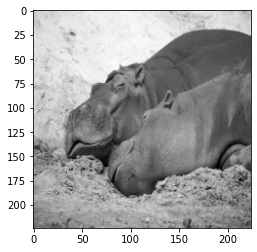

In [8]:
idx = 29
plt.imshow(train_images[idx][0], cmap="gray")

## Convert to torch tensors

In [9]:
X_train = torch.tensor(train_images).type(torch.float32)
y_train = torch.tensor(train_labels).type(torch.long)

X_train.size(), y_train.size()

(torch.Size([800, 1, 224, 224]), torch.Size([800]))

## Normalize the data

In [10]:
mean = X_train.mean()
std = X_train.std()

In [11]:
normalizer = transforms.Normalize(mean, std)

In [12]:
X_train.max(), X_train.mean(), X_train.std()

(tensor(255.), tensor(117.3645), tensor(57.7698))

In [13]:
X_train_norm = normalizer(X_train)

In [14]:
X_train_norm.max(), X_train_norm.mean(), X_train_norm.std()

(tensor(2.3825), tensor(-1.7828e-07), tensor(1.))

In [15]:
X_train_norm.shape

torch.Size([800, 1, 224, 224])

## One hot the labels

In [16]:
y_train_onehot = F.one_hot(y_train, N_CLASSES).type(torch.float32)
y_train_onehot.size()

torch.Size([800, 2])

## Create datasets and dataloaders for training

In [17]:
from sklearn.model_selection import train_test_split

def train_val_dataset(dataset, val_split=TEST_SIZE):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

In [18]:
dataset = TensorDataset(X_train_norm, y_train_onehot)

train_dataset, val_dataset = train_val_dataset(dataset, TEST_SIZE)

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Define the structure of the ConvNet

In [19]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        
        # We first define the convolution and pooling layers as a features extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, (5, 5), stride=1, padding=2),
            # nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            
            nn.Conv2d(16, 32, (5, 5), stride=1, padding=2),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            
            nn.Conv2d(32, 32, (5, 5), stride=1, padding=2),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )

        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(25088, 10000),
            nn.ReLU(),
            nn.Linear(10000, 5000),
            nn.ReLU(),
            nn.Linear(5000, 512),
            nn.ReLU(),
            nn.Linear(512, N_CLASSES),
        )        
        
    # Method called when we apply the network to an input batch
    def forward(self, X):
        bsize = X.size(0) # batch size
        output = self.features(X) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output

## The optimisation loop

In [20]:
def main(train_loader, val_loader, model, lr=0.03, epochs=5, device=device):
    
    model = model.to(device)
    loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr)
    
    train_loss_per_epoch = []
    train_acc_per_epoch  = []
      
    val_loss_per_epoch = []
    val_acc_per_epoch  = []
    
    for e in tqdm(range(epochs)):
        n_batches = 0
        l_train = 0
        acc_train = 0
        n_samples = 0
        
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            
            n_samples += x.size(0)
            
            yhat = model(x)
            l = loss(yhat, y)
            
            _, YhatInd = torch.max(yhat, 1)
            _, YInd    = torch.max(y, 1)
            
            l_train   += l.item()
            acc_train += torch.where(YhatInd == YInd, 1, 0).sum().item()
            
            optim.zero_grad()
            l.backward()
            optim.step()
            
            n_batches += 1
            
        train_loss_per_epoch.append(l_train / n_batches)
        train_acc_per_epoch.append(acc_train / n_samples)
        
        with torch.no_grad():
            n_batches = 0
            l_val     = 0
            acc_val   = 0
            n_samples = 0
            
            for x, y in val_loader:
                
                x = x.to(device)
                y = y.to(device)
            
                n_batches += 1
                n_samples += x.size(0)

                yhat = model(x)
                l = loss(yhat, y)

                _, YhatInd = torch.max(yhat, 1)
                _, YInd    = torch.max(y, 1)

                l_val   += l.item()
                acc_val += torch.where(YhatInd == YInd, 1, 0).sum().item()
             
            val_loss_per_epoch.append(l_val / n_batches)
            val_acc_per_epoch.append(acc_val / n_samples)
            
    return {
        "train_loss" : train_loss_per_epoch,
        "train_accuracy" : train_acc_per_epoch,
        "val_loss" : val_loss_per_epoch,
        "val_accuracy" : val_acc_per_epoch
    }

## Training a ConvNet 

In [187]:
model = ConvNet()

In [188]:
training_result = main(train_loader, val_loader, model, lr=0.03, epochs=20, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

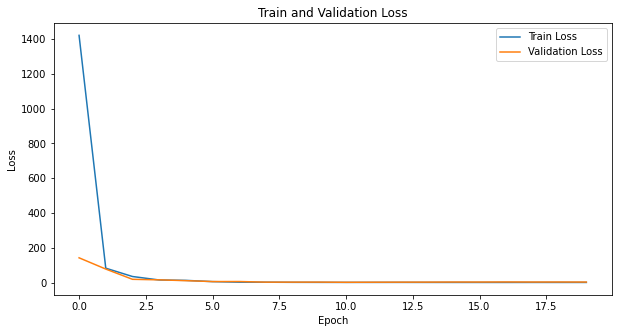

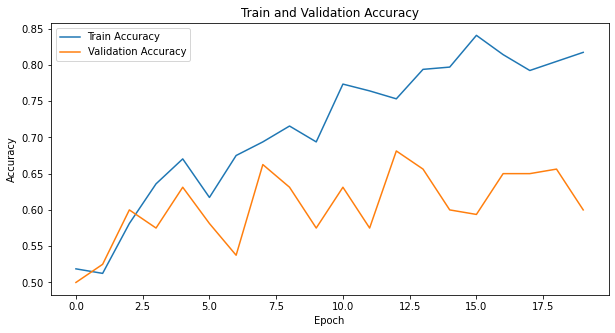

In [92]:
# Plot des pertes d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(training_result["train_loss"], label='Train Loss')
plt.plot(training_result["val_loss"], label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot des précisions d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(training_result["train_accuracy"], label='Train Accuracy')
plt.plot(training_result["val_accuracy"], label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()